In [301]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.legend_handler import HandlerTuple
import seaborn as sns
import math
import os
import statistics

In [302]:
PATH = "../../data/finals_frameworks"

files = os.listdir(PATH)
files = [x for x in files if 'csv' in x]

In [303]:
file_data = []
diff_means = []
diff_program_means_dict = {'none': [], 'windup': [], 'getpixel': [], 'bitblt': [], 'getdbits': []}
for file in files:
    data_in = pd.read_csv(f"{PATH}/{file}", index_col=False)
    try:
        mean = data_in.query("fw != -1")['diff'].mean()
        if not math.isnan(mean):
            diff_means.append(mean/1000)
            diff_program_means_dict[data_in['program'][1]].append(mean/1000)
    except:
        #print(data_in, file)
        pass
    file_data.append(data_in)
    
data = pd.concat(file_data)

In [304]:
data['ete_upper'] = data['ete_upper'] / 1000
data['ete_lower'] = data['ete_lower'] / 1000
data['fw'] = data['fw'] / 1000
data['diff'] = data['diff'] / 1000
data

,Unnamed: 0,id,threshold,framework,complexity,framework_complexity,fullscreen,fullscreen_mode,program,ete_upper,ete_lower,fw,diff
0,0,0,2313,Blend2D,default,Blend2D_default,fullscreen,2.0,bitblt,11.291,13.603,4.887,6.404
1,1,1,2313,Blend2D,default,Blend2D_default,fullscreen,2.0,bitblt,12.327,14.641,6.417,5.910
2,2,2,2313,Blend2D,default,Blend2D_default,fullscreen,2.0,bitblt,11.633,13.950,5.467,6.166
3,3,3,2313,Blend2D,default,Blend2D_default,fullscreen,2.0,bitblt,12.471,14.785,6.739,5.732
4,4,4,2313,Blend2D,default,Blend2D_default,fullscreen,2.0,bitblt,11.277,13.592,5.210,6.067
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,195,3874,wxpython,rects,wxpython_rects,fullscreen,2.0,windup,43.989,0.338,40.566,3.423
196,196,196,3874,wxpython,rects,wxpython_rects,fullscreen,2.0,windup,41.916,0.509,38.535,3.381
197,197,197,3874,wxpython,rects,wxpython_rects,fullscreen,2.0,windup,43.320,0.346,39.826,3.494
198,198,198,3874,wxpython,rects,wxpython_rects,fullscreen,2.0,windup,44.345,0.689,40.669,3.676


In [305]:
data = data[data['complexity'] == 'default']
data = data[data['fullscreen'] == 'fullscreen']

data_getpixel = data[data['program'] == 'getpixel']
data_bitblt = data[data['program'] == 'bitblt']
data_getdbits = data[data['program'] == 'getdbits']
data_windup = data[data['program'] == 'windup']
data_none = data[data['program'] == 'none']

In [306]:
diff_mean_getpixel = statistics.mean(diff_program_means_dict['getpixel'])
diff_mean_bitblt = statistics.mean(diff_program_means_dict['bitblt'])
diff_mean_getdbits = statistics.mean(diff_program_means_dict['getdbits'])
diff_mean_windup = statistics.mean(diff_program_means_dict['windup'])
# agg_mean = round(np.mean(diff_program_means_dict['getpixel'][1]), 1) - macht das was andres??

In [307]:
data_std_diffs = pd.DataFrame()
data_std_diffs['getpixel'] = data_getpixel[['diff']].std()
data_std_diffs['getdbits'] = data_getdbits[['diff']].std()
data_std_diffs['bitblt'] = data_bitblt[['diff']].std()
data_std_diffs['windup'] = data_windup[['diff']].std()
data_std_diffs

,getpixel,getdbits,bitblt,windup
diff,26.361671,3.051046,3.07146,117.814554


In [346]:
# overall count
print(len(data_getpixel))
print(len(data_bitblt))
print(len(data_getdbits))
print(len(data_windup))

6000
5800
5800
6000


In [348]:
68/5800

0.011724137931034483

In [308]:
negative_counts = {
    'getpixel': (data_getpixel['diff'] < 0).sum(),
    'getdbits': (data_getdbits['diff'] < 0).sum(),
    'bitblt': (data_bitblt['diff'] < 0).sum(),
    'windup': (data_windup['diff'] < 0).sum()
}

data_negative_count = pd.DataFrame(list(negative_counts.items()), columns=['program', 'number of negative diffs'])
data_negative_count


,program,number of negative diffs
0,getpixel,1
1,getdbits,4
2,bitblt,9
3,windup,68


In [309]:
# sns.set_theme(style="whitegrid", context="paper", font_scale=1.3, rc={'figure.figsize':(25, 10), "xtick.bottom": True, "grid.linestyle": ":"})

# plot = sns.stripplot(data=data[data['program'] != 'none'], x='framework', y='diff', hue='program', hue_order=['getpixel', 'bitblt', 'getdbits', 'windup'], size=2, dodge=True, palette=['red', 'orange', 'darkred', 'blue'])
# # plot = sns.boxplot(data=data[data['program'] != 'none'], x='framework', y='diff', hue='program', hue_order=['getpixel', 'bitblt', 'getdbits', 'windup'], dodge=True, palette=['red', 'orange', 'darkred', 'blue'])
# plot.axes.set_ylim(-25, 50)
# plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

# plt.axhline(diff_mean_getpixel, color='red')
# plt.axhline(diff_mean_bitblt, color='orange')
# plt.axhline(diff_mean_getdbits, color='darkred')
# plt.axhline(diff_mean_windup, color='blue')


(0.0, 40.0)

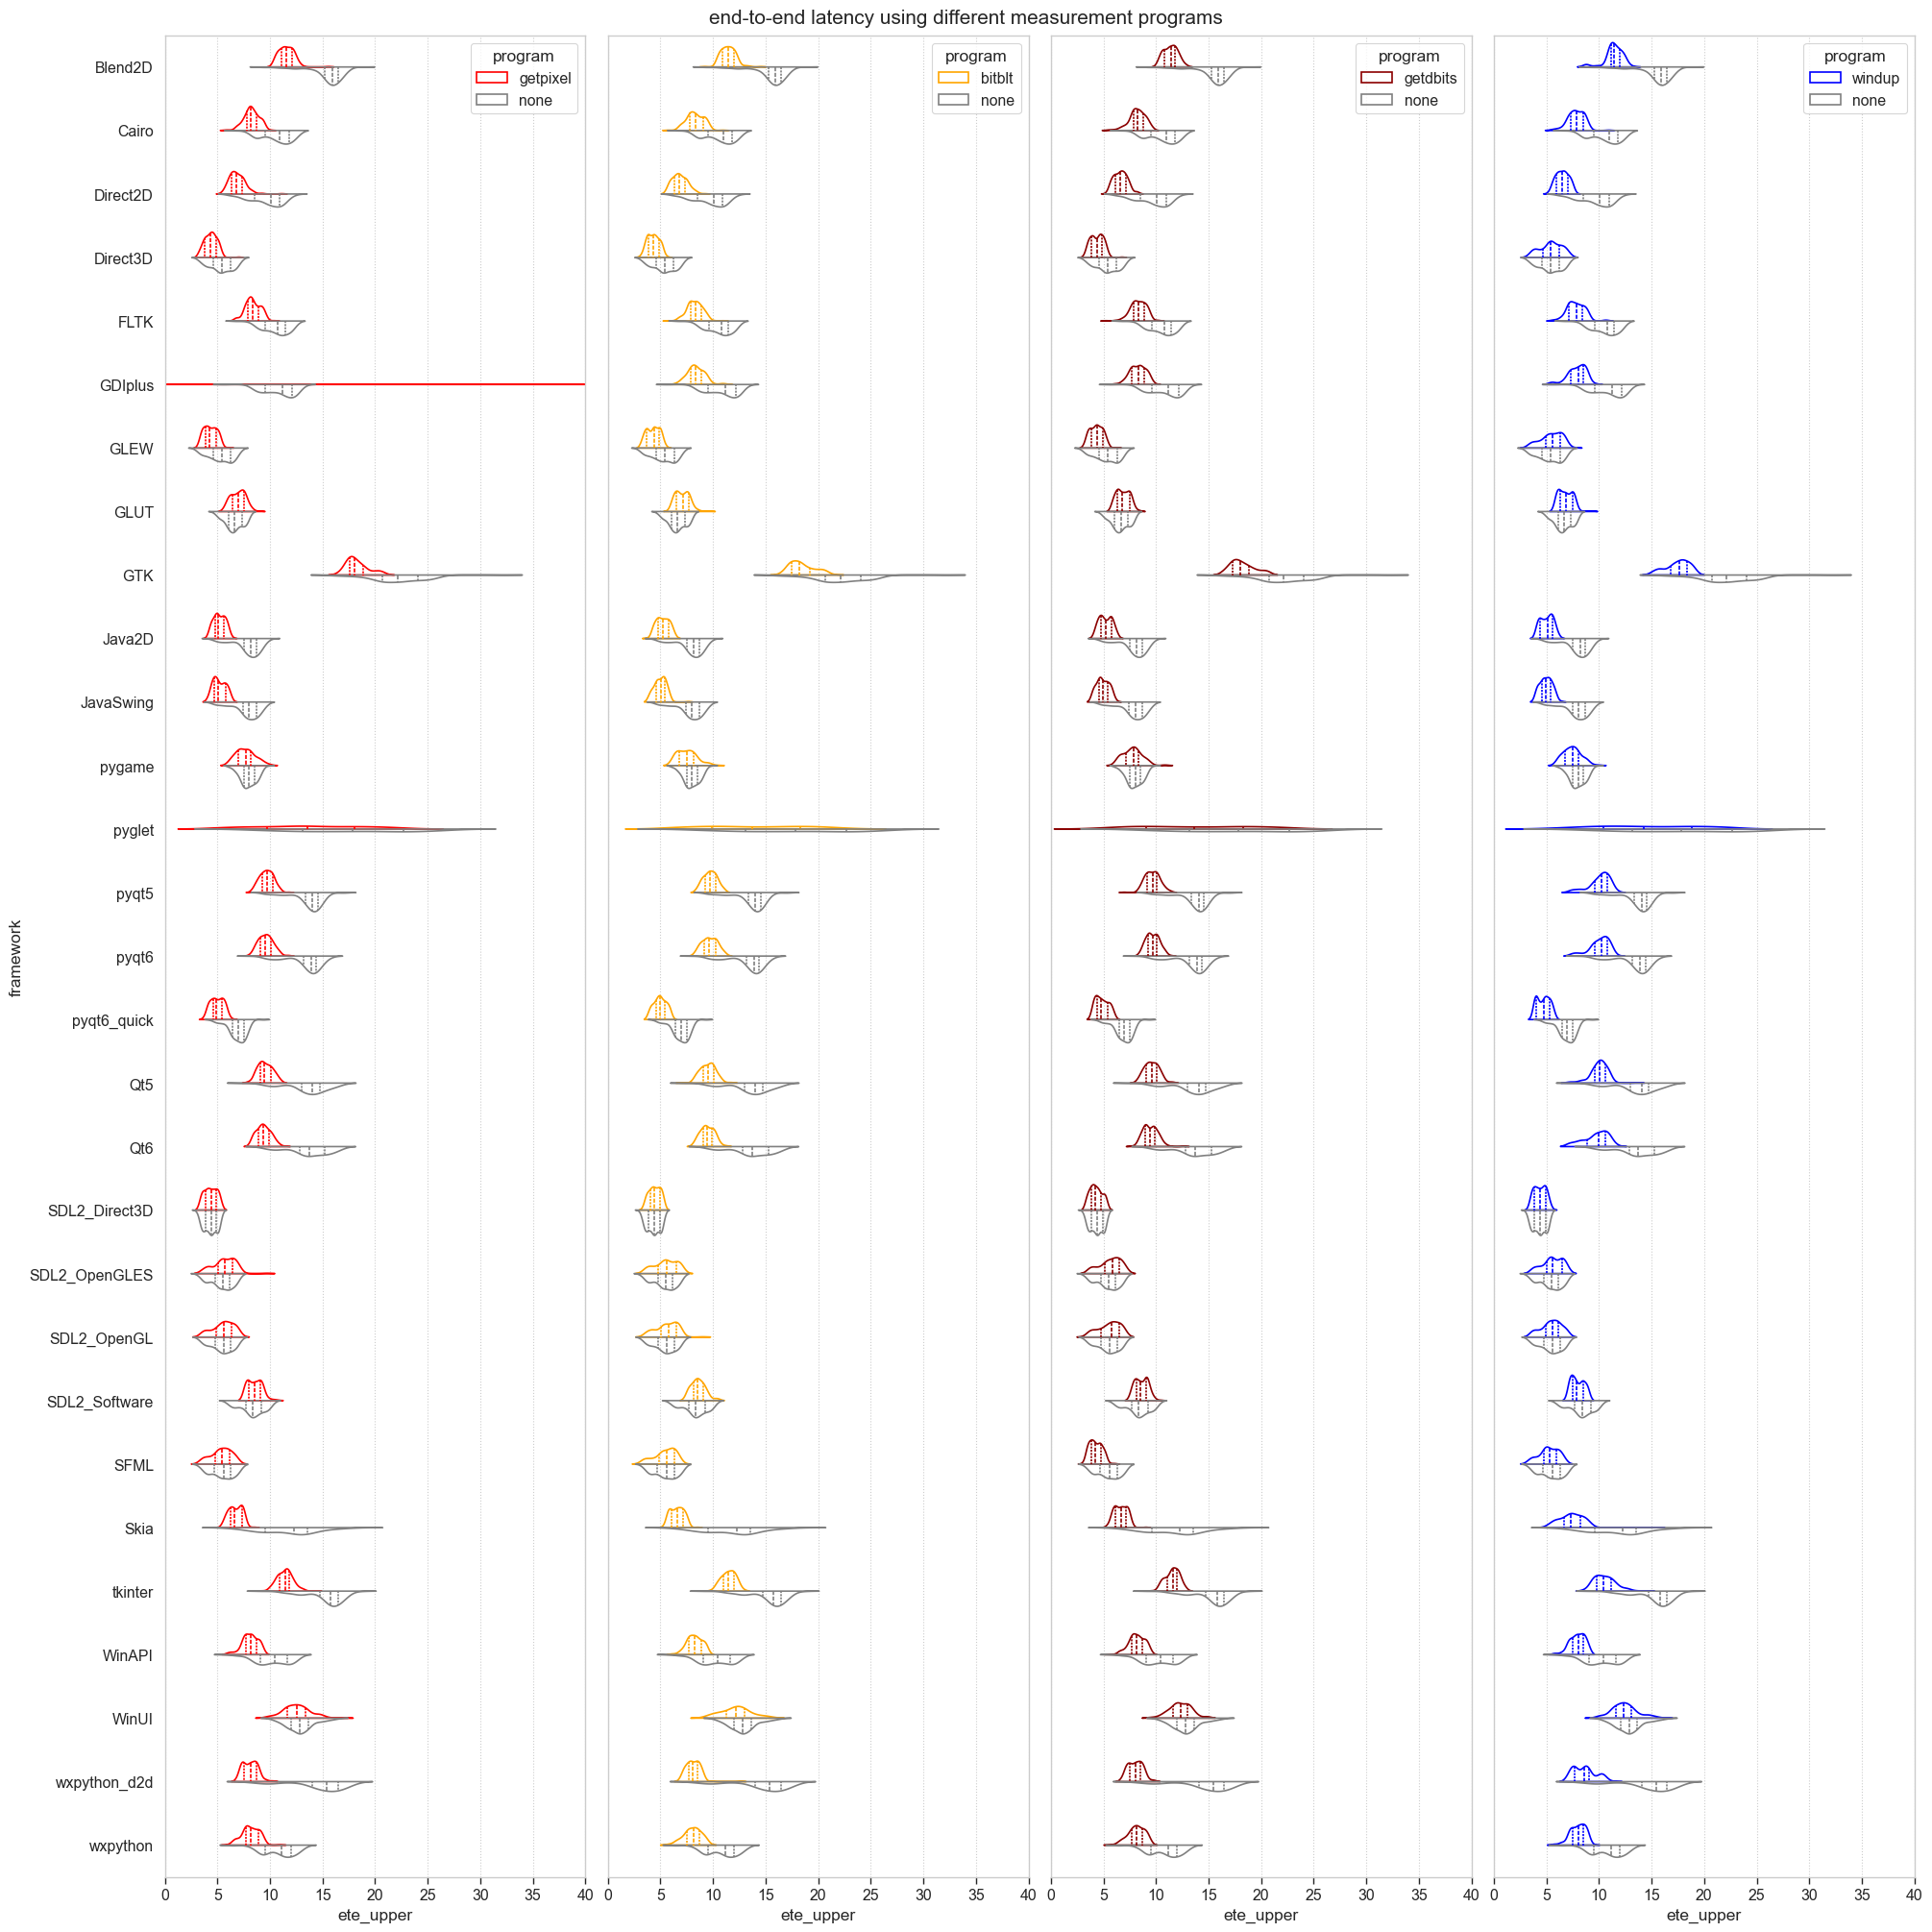

In [310]:
data_temp_getpixel = pd.concat([data_getpixel, data_none])
data_temp_bitblt = pd.concat([data_bitblt, data_none])
data_temp_getdbits = pd.concat([data_getdbits, data_none])
data_temp_windup = pd.concat([data_windup, data_none])

fig, axs = plt.subplots(1, 4, layout='constrained', sharex=True, sharey=True, figsize=(20, 20))
fig.suptitle("end-to-end latency using different measurement programs")

plot = sns.violinplot(ax=axs[0], data=data_temp_getpixel, x='ete_upper', y='framework', hue='program', hue_order=['getpixel', 'none'], split=True, fill=False, inner='quart', palette=['red', 'grey'])
plot.axes.set_xlim(0, 40)

plot = sns.violinplot(ax=axs[1], data=data_temp_bitblt, x='ete_upper', y='framework', hue='program', hue_order=['bitblt', 'none'], split=True, fill=False, inner='quart', palette=['orange', 'grey'])
plot.axes.set_xlim(0, 40)

plot = sns.violinplot(ax=axs[2], data=data_temp_getdbits, x='ete_upper', y='framework', hue='program', hue_order=['getdbits', 'none'], split=True, fill=False, inner='quart', palette=['darkred', 'grey'])
plot.axes.set_xlim(0, 40)

plot = sns.violinplot(ax=axs[3], data=data_temp_windup, x='ete_upper', y='framework', hue='program', hue_order=['windup', 'none'], split=True, fill=False, inner='quart', palette=['blue', 'grey'])
plot.axes.set_xlim(0, 40)
# plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

In [311]:
COLOR_GLUTROT = '#DA3C43'
COLOR_HEIDENELKE = '#9C004B'

COLOR_BLUE= '#5CABFF'
COLOR_DARKBLUE = '#18206F'

COLOR_GREEN = '#7dff1a'
COLOR_DARKGREEN = '#4FB800'

COLOR_OCKER_ANDI_ORIGINAL = '#ebb300'
COLOR_OCKER_ANDI = '#EC7F00'
COLOR_OCKER = '#EA5C21'

COLOR_NONE = '#8E8E8D'
COLOR_NONE_DARK = '#4E4E4D'

PALETTE_LIGHT = [COLOR_BLUE, COLOR_GREEN, COLOR_GLUTROT, COLOR_OCKER_ANDI]
PALETTE_DARK = [COLOR_DARKBLUE, COLOR_DARKGREEN, COLOR_HEIDENELKE, COLOR_OCKER]

C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_9120\3921466172.py:10: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  plot = sns.pointplot(ax=axs[0], data=data_temp_windup, x='ete_upper', y='framework', hue='program', hue_order=['windup', 'none'], palette=[COLOR_HEIDENELKE, COLOR_NONE_DARK], dodge=0.4, join=False, errorbar='sd', markersize=6, zorder=2)
C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_9120\3921466172.py:14: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  plot = sns.pointplot(ax=axs[1], data=data_temp_getpixel, x='ete_upper', y='framework', hue='program', hue_order=['getpixel', 'none'], palette=[COLOR_OCKER, COLOR_NONE_DARK], dodge=0.4, join=False, errorbar='sd', markersize=6, zorder=2)
C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_9120\3921466172.py:18: UserWarning: 

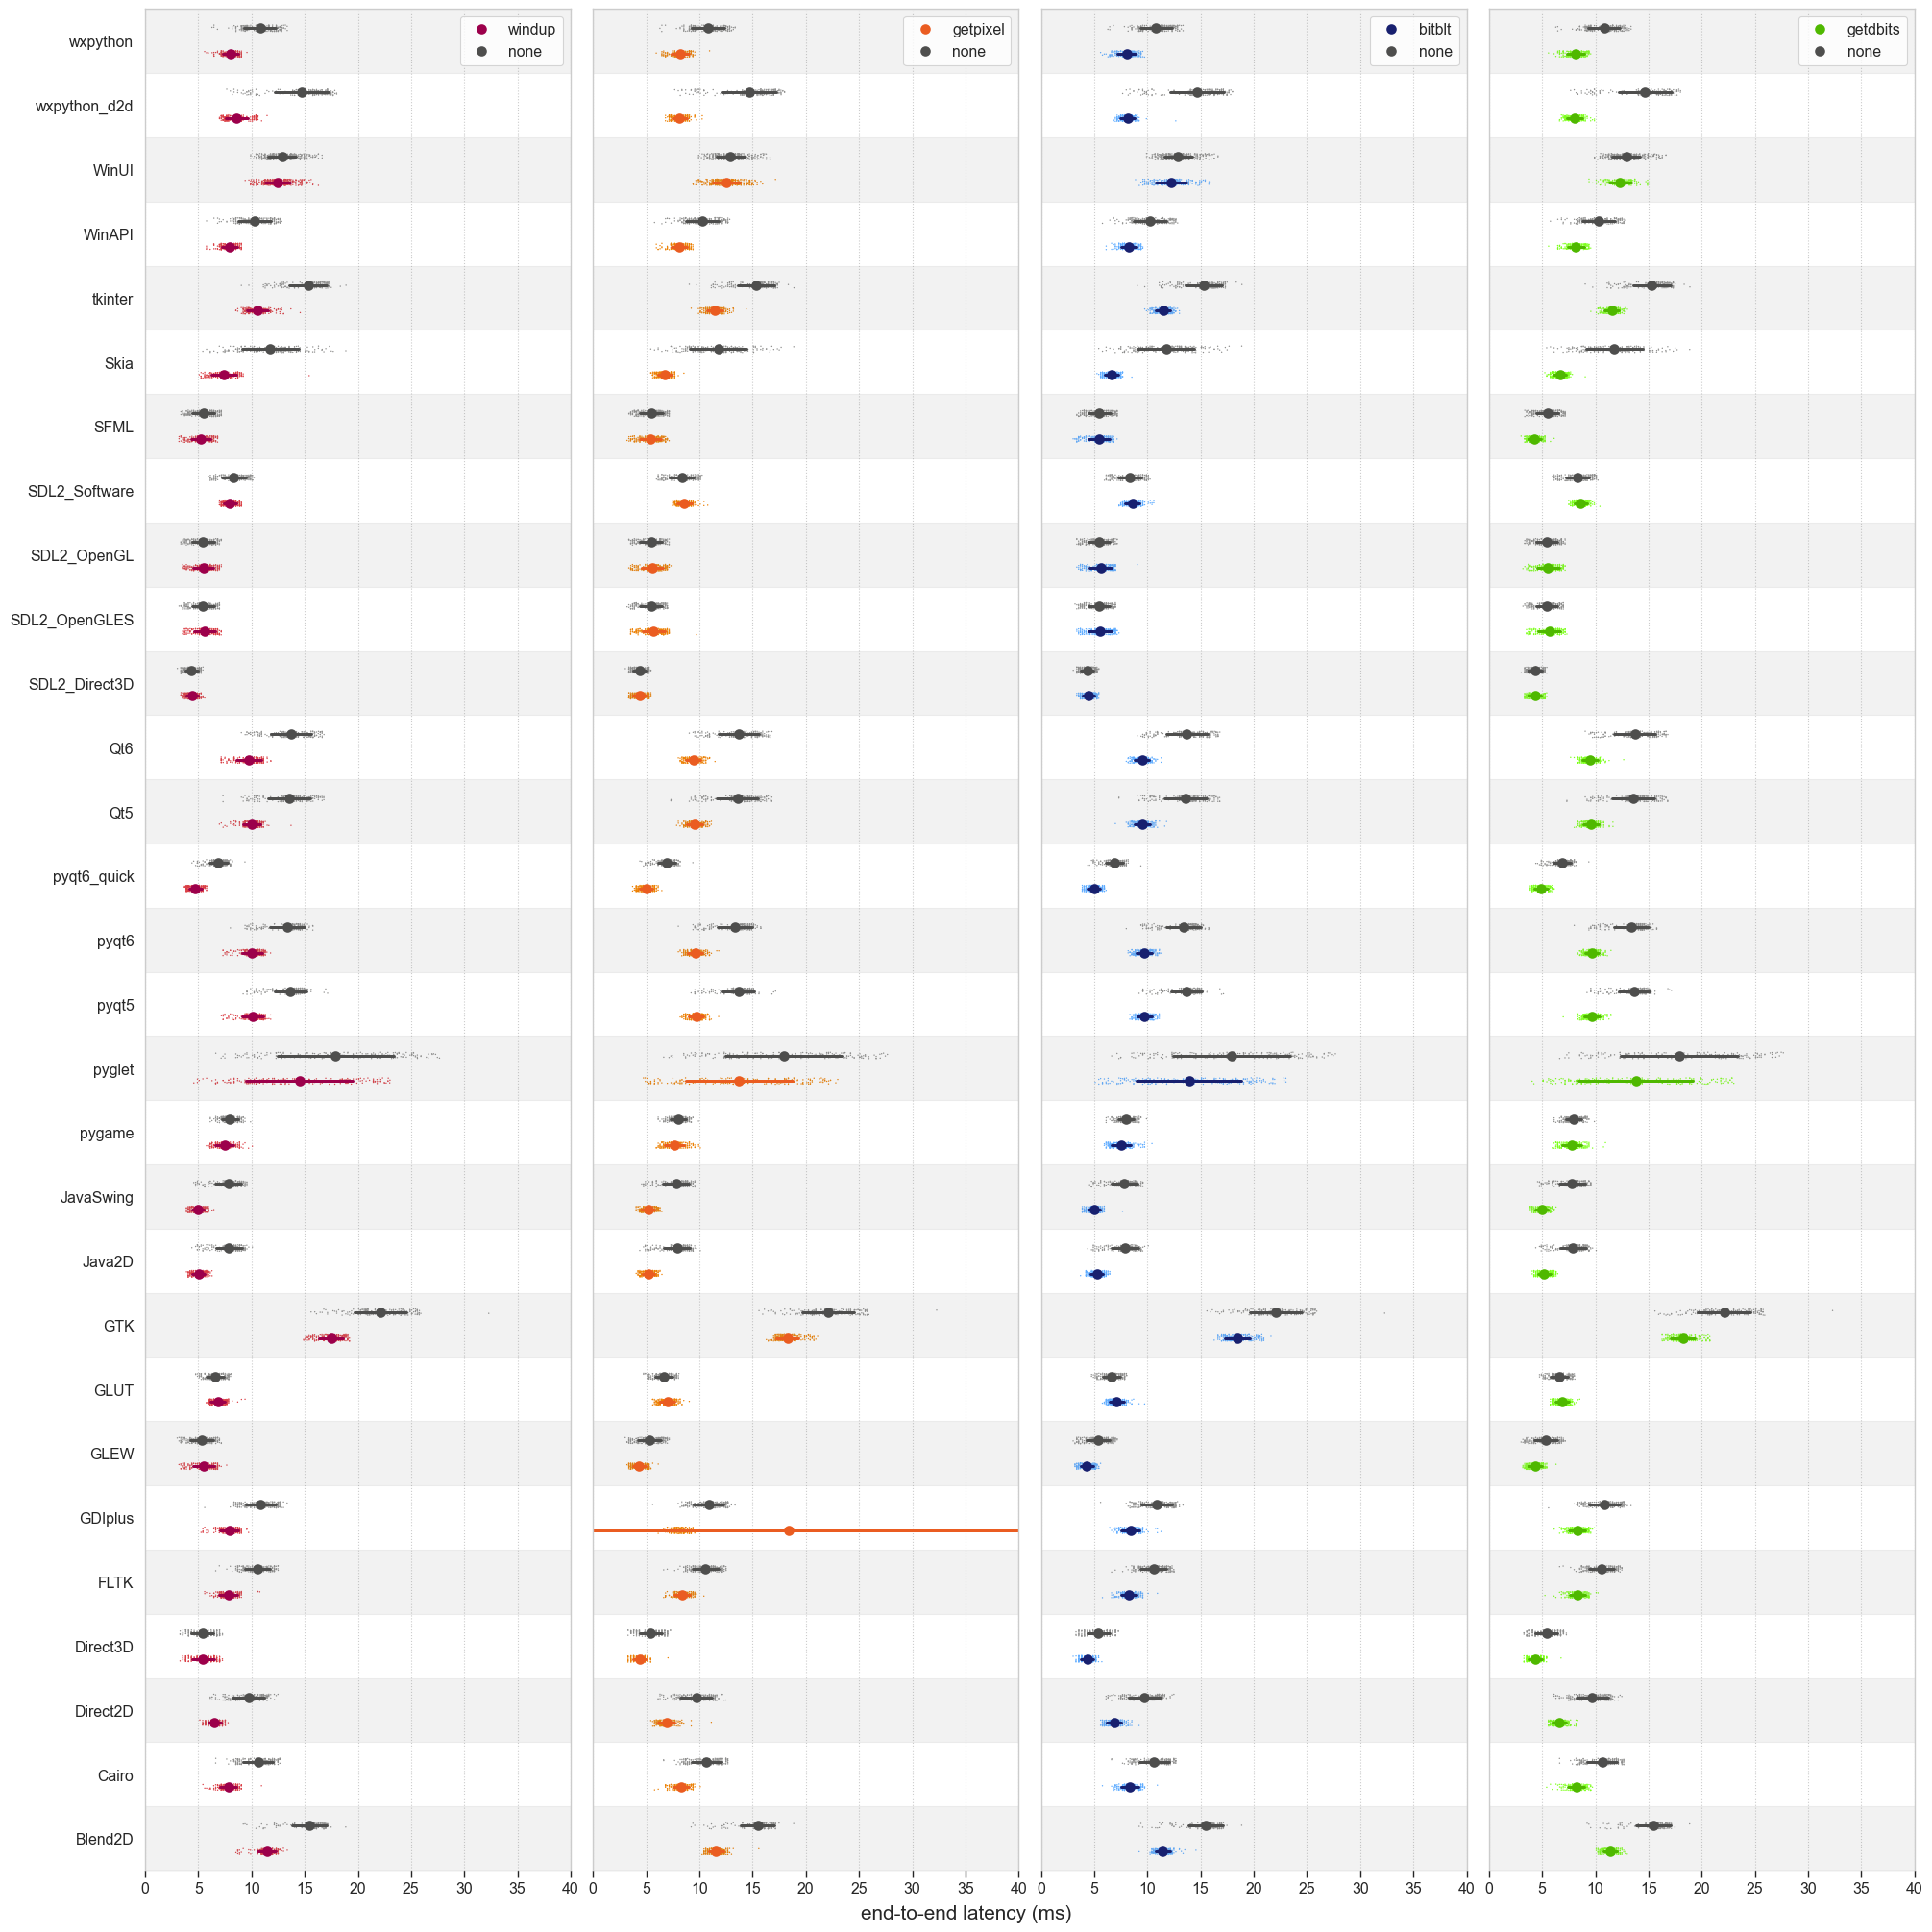

In [312]:
data_temp_getpixel = pd.concat([data_getpixel, data_none])
data_temp_bitblt = pd.concat([data_bitblt, data_none])
data_temp_getdbits = pd.concat([data_getdbits, data_none])
data_temp_windup = pd.concat([data_windup, data_none])

fig, axs = plt.subplots(1, 4, layout='constrained', sharex=True, sharey=True, figsize=(20, 20))
# fig.suptitle("end-to-end latency using different measurement programs")

plot = sns.stripplot(ax=axs[0], data=data_temp_windup, x='ete_upper', y='framework', hue='program', hue_order=['windup', 'none'], palette=[COLOR_GLUTROT, COLOR_NONE], size=1, zorder=1, dodge=0.4, legend=False)
plot = sns.pointplot(ax=axs[0], data=data_temp_windup, x='ete_upper', y='framework', hue='program', hue_order=['windup', 'none'], palette=[COLOR_HEIDENELKE, COLOR_NONE_DARK], dodge=0.4, join=False, errorbar='sd', markersize=6, zorder=2)
plot.axes.set_xlim(0, 40)

plot = sns.stripplot(ax=axs[1], data=data_temp_getpixel, x='ete_upper', y='framework', hue='program', hue_order=['getpixel', 'none'], palette=[COLOR_OCKER_ANDI, COLOR_NONE], size=1, zorder=1, dodge=0.4, legend=False)
plot = sns.pointplot(ax=axs[1], data=data_temp_getpixel, x='ete_upper', y='framework', hue='program', hue_order=['getpixel', 'none'], palette=[COLOR_OCKER, COLOR_NONE_DARK], dodge=0.4, join=False, errorbar='sd', markersize=6, zorder=2)
plot.axes.set_xlim(0, 40)

plot = sns.stripplot(ax=axs[2], data=data_temp_bitblt, x='ete_upper', y='framework', hue='program', hue_order=['bitblt', 'none'], palette=[COLOR_BLUE, COLOR_NONE], size=1, zorder=1, dodge=0.4, legend=False)
plot = sns.pointplot(ax=axs[2], data=data_temp_bitblt, x='ete_upper', y='framework', hue='program', hue_order=['bitblt', 'none'], palette=[COLOR_DARKBLUE, COLOR_NONE_DARK], dodge=0.4, join=False, errorbar='sd', markersize=6, zorder=2)
plot.axes.set_xlim(0, 40)

plot = sns.stripplot(ax=axs[3], data=data_temp_getdbits, x='ete_upper', y='framework', hue='program', hue_order=['getdbits', 'none'], palette=[COLOR_GREEN, COLOR_NONE], size=1, zorder=1, dodge=0.4, legend=False)
plot = sns.pointplot(ax=axs[3], data=data_temp_getdbits, x='ete_upper', y='framework', hue='program', hue_order=['getdbits', 'none'], palette=[COLOR_DARKGREEN, COLOR_NONE_DARK], dodge=0.4, join=False, errorbar='sd', markersize=6, zorder=2)
plot.axes.set_xlim(0, 40)

# stripped background
for i in range(len(data['framework'].unique())):
    if i % 2 == 0:
        axs[0].axhspan(i - 0.5, i + 0.5, color=COLOR_NONE, alpha=0.1)
        axs[1].axhspan(i - 0.5, i + 0.5, color=COLOR_NONE, alpha=0.1)
        axs[2].axhspan(i - 0.5, i + 0.5, color=COLOR_NONE, alpha=0.1)
        axs[3].axhspan(i - 0.5, i + 0.5, color=COLOR_NONE, alpha=0.1)
axs[0].set_ylim(-0.5, len(data['framework'].unique()) - 0.5)
axs[1].set_ylim(-0.5, len(data['framework'].unique()) - 0.5)
axs[2].set_ylim(-0.5, len(data['framework'].unique()) - 0.5)
axs[3].set_ylim(-0.5, len(data['framework'].unique()) - 0.5)

axs[0].set_ylabel('')
axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')
axs[3].set_xlabel('')
fig.supxlabel('end-to-end latency (ms)')

axs[0].legend(title='')
axs[1].legend(title='')
axs[2].legend(title='')
axs[3].legend(title='')

C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_9120\3543419221.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


[Text(0, 0, 'Blend2D'),
 Text(1, 0, 'Cairo'),
 Text(2, 0, 'Direct2D'),
 Text(3, 0, 'Direct3D'),
 Text(4, 0, 'FLTK'),
 Text(5, 0, 'GDIplus'),
 Text(6, 0, 'GLEW'),
 Text(7, 0, 'GLUT'),
 Text(8, 0, 'GTK'),
 Text(9, 0, 'Java2D'),
 Text(10, 0, 'JavaSwing'),
 Text(11, 0, 'pygame'),
 Text(12, 0, 'pyglet'),
 Text(13, 0, 'pyqt5'),
 Text(14, 0, 'pyqt6'),
 Text(15, 0, 'pyqt6_quick'),
 Text(16, 0, 'Qt5'),
 Text(17, 0, 'Qt6'),
 Text(18, 0, 'SDL2_Direct3D'),
 Text(19, 0, 'SDL2_OpenGLES'),
 Text(20, 0, 'SDL2_OpenGL'),
 Text(21, 0, 'SDL2_Software'),
 Text(22, 0, 'SFML'),
 Text(23, 0, 'Skia'),
 Text(24, 0, 'tkinter'),
 Text(25, 0, 'WinAPI'),
 Text(26, 0, 'WinUI'),
 Text(27, 0, 'wxpython_d2d'),
 Text(28, 0, 'wxpython')]

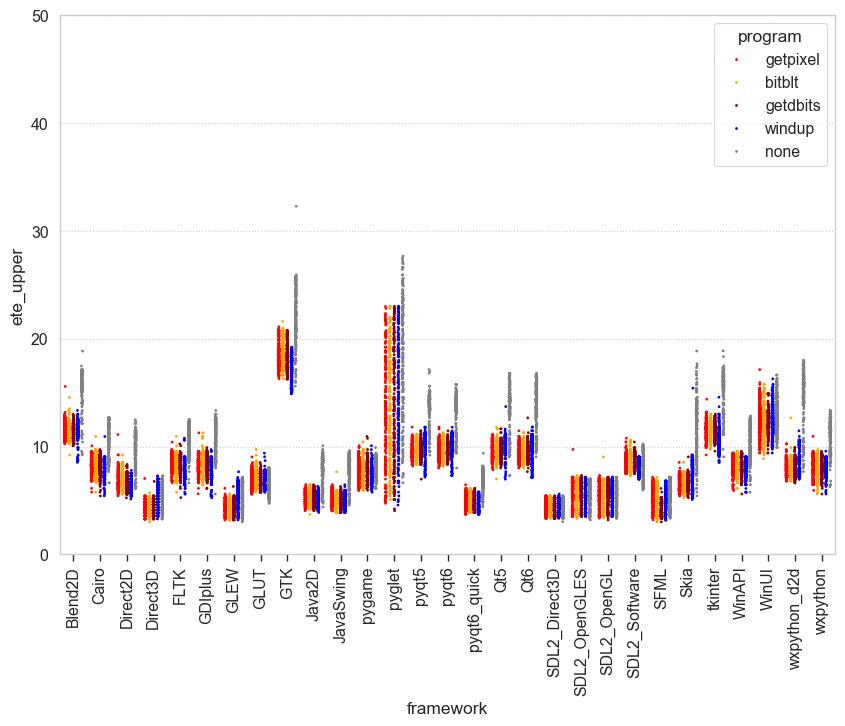

In [313]:
plot = sns.stripplot(data=data, x='framework', y='ete_upper', hue='program', hue_order=['getpixel', 'bitblt', 'getdbits', 'windup', 'none'], size=2, dodge=True, palette=['red', 'orange', 'darkred', 'blue', 'grey'])
plot.axes.set_ylim(0, 50)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

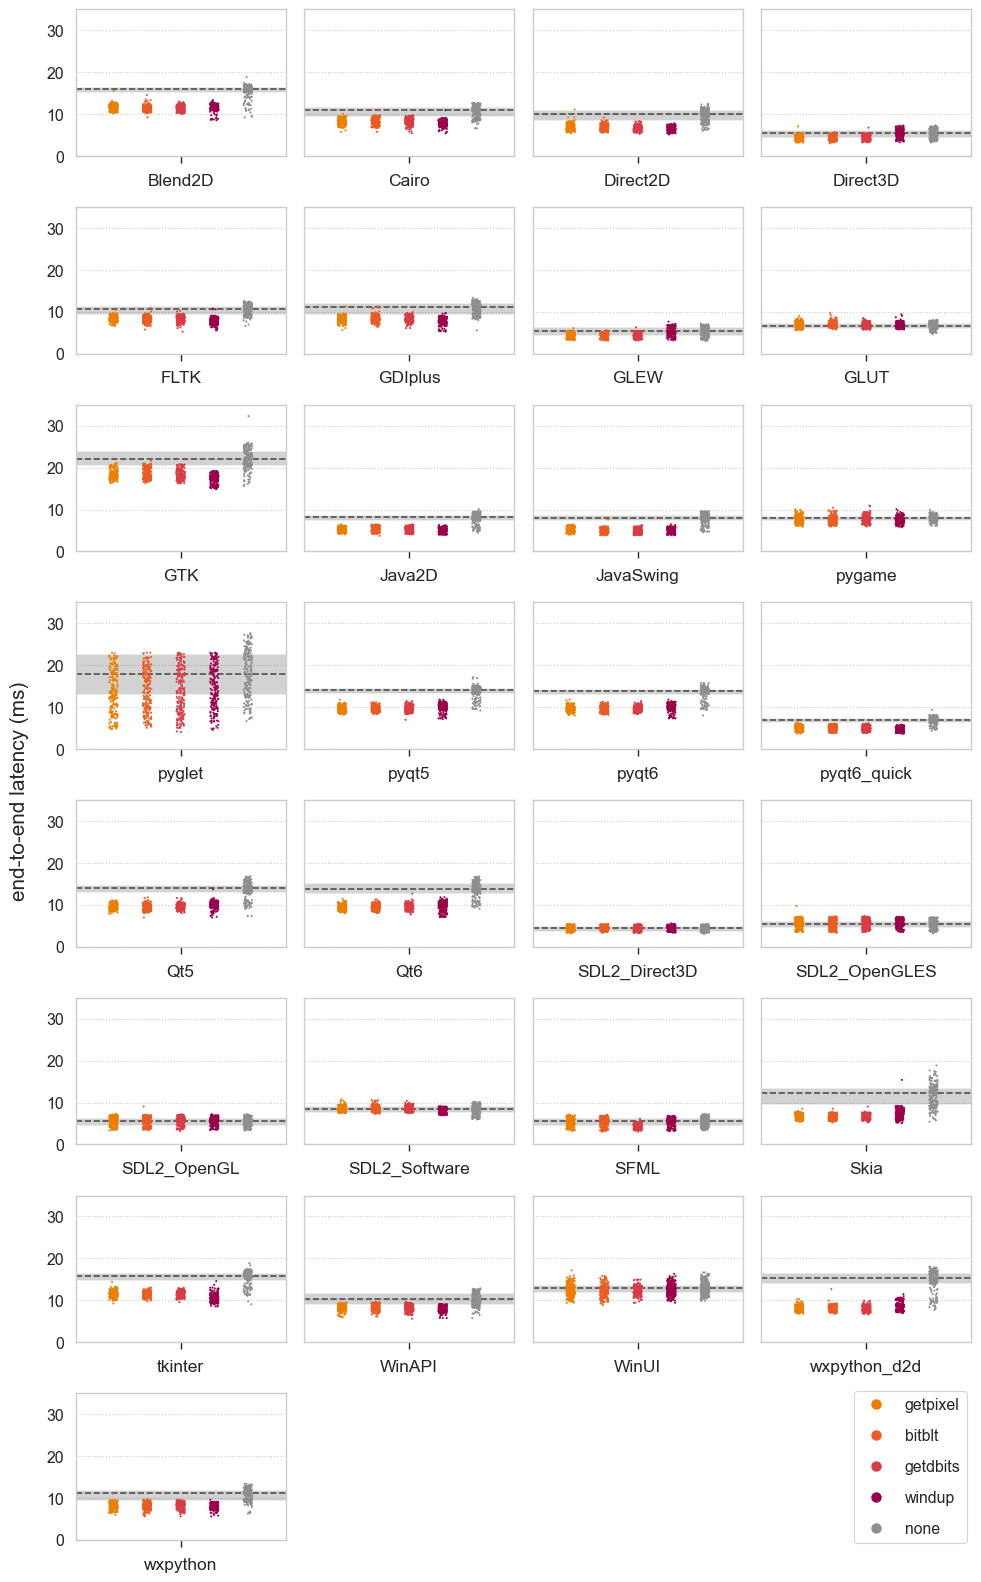

In [314]:
sns.set_theme(style="whitegrid", context="paper", font_scale=1.3, rc={'figure.figsize':(10, 7), "xtick.bottom": True, "grid.linestyle": ":"})
fig, axes = plt.subplots(8, 4, figsize=(10, 16), sharex=False, sharey=True)
fig.supylabel('end-to-end latency (ms)')

# Flatten the axes array to iterate over it more easily
axes_flat = axes.flatten()

# Iterate over the unique frameworks and plot in each subplot
for i, (framework, ax) in enumerate(zip(data['framework'].unique(), axes_flat)):
    # plot = sns.boxplot(ax=ax, data=data[data['framework'] == framework], x='program', y='ete_upper', order=['getpixel', 'bitblt', 'getdbits', 'windup', 'none'], palette=['grey', 'grey', 'grey', 'grey', 'darkred'], fill=False)
    plot = sns.stripplot(ax=ax, data=data[data['framework'] == framework], y='ete_upper', hue='program', hue_order=['getpixel', 'bitblt', 'getdbits', 'windup', 'none'], palette=[COLOR_OCKER_ANDI, COLOR_OCKER, COLOR_GLUTROT, COLOR_HEIDENELKE, COLOR_NONE], size=1.5, dodge=True)
    handles, labels = plot.get_legend_handles_labels()
    legend = plot.get_legend()
    ax.legend().set_visible(False)
    ax.set_ylim(0, 35)
    ax.set_xlabel(framework)
    ax.set_ylabel('')
    ax.axhline(data_none[data_none['framework'] == framework]['ete_upper'].median(), color=COLOR_NONE_DARK, alpha=1, linestyle='--')
    try:
        quant_25 = np.percentile(data_none[data_none['framework'] == framework]['ete_upper'], 25)
        quant_75 = np.percentile(data_none[data_none['framework'] == framework]['ete_upper'], 75)
        ax.axhspan(quant_25, quant_75, facecolor=COLOR_NONE_DARK, alpha=0.25, label="test")
    except:
        pass


axes.flat[-1].set_visible(False)
axes.flat[-2].set_visible(False)
axes.flat[-3].set_visible(False)


legend = fig.legend(handles, labels, loc='lower right', markerscale=5., bbox_to_anchor=(0.985, 0.025), labelspacing=1)


# handles_getpixel = (handles[0], handles[1], handles[2], handles[3])
# handles_windup = (handles[4], handles[5], handles[6], handles[7])

# handles_default = (handles[0], handles[4])
# handles_image = (handles[1], handles[5])
# handles_rects = (handles[2], handles[6])
# handles_3d = (handles[3], handles[7])

# condition_legend = plot.legend([handles_default, handles_image, handles_rects, handles_3d], ['default', 'image', 'rects', '3D'], markerscale=5., loc='upper right', handler_map={tuple: HandlerTuple(ndivide=None)})
# program_legend = plot.legend([handles_windup, handles_getpixel], ['windup', 'getpixel'], markerscale=5., loc='upper right', handler_map={tuple: HandlerTuple(ndivide=None)})
# plt.gca().add_artist(condition_legend)
# plt.gca().add_artist(program_legend)



plt.tight_layout() 
plt.savefig("validation_ete.pdf", format='pdf')

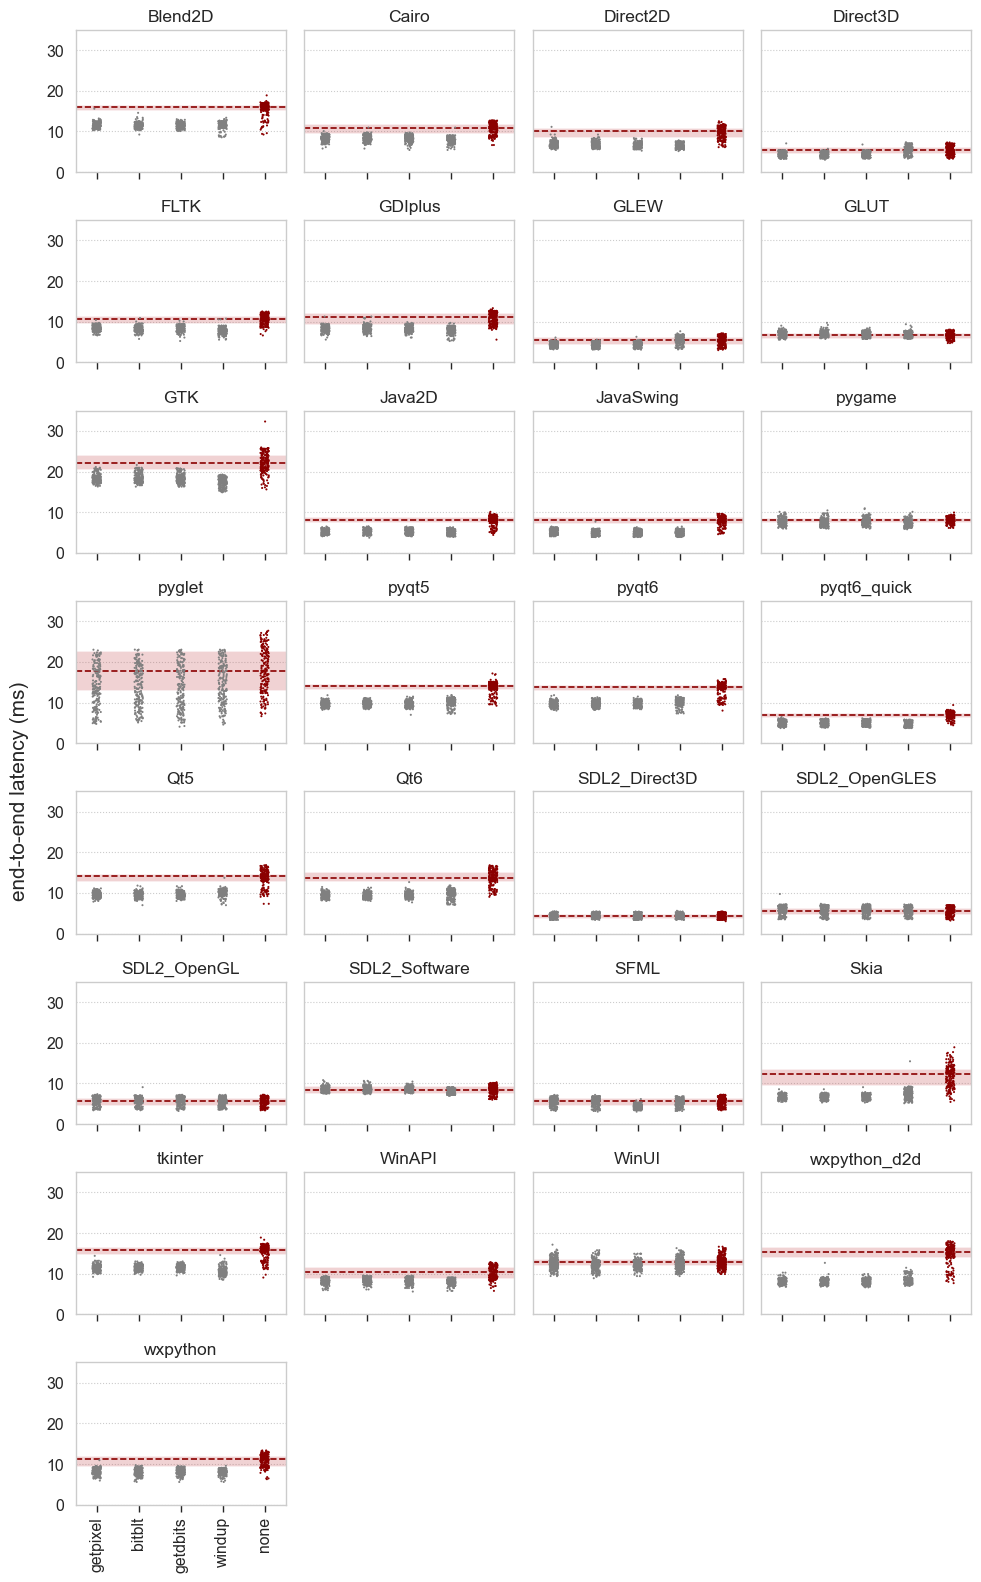

In [315]:
sns.set_theme(style="whitegrid", context="paper", font_scale=1.3, rc={'figure.figsize':(10, 7), "xtick.bottom": True, "grid.linestyle": ":"})
fig, axes = plt.subplots(8, 4, figsize=(10, 16), sharex=True, sharey=True)
fig.supylabel('end-to-end latency (ms)')

# Flatten the axes array to iterate over it more easily
axes_flat = axes.flatten()

# Iterate over the unique frameworks and plot in each subplot
for i, (framework, ax) in enumerate(zip(data['framework'].unique(), axes_flat)):
    # plot = sns.boxplot(ax=ax, data=data[data['framework'] == framework], x='program', y='ete_upper', order=['getpixel', 'bitblt', 'getdbits', 'windup', 'none'], palette=['grey', 'grey', 'grey', 'grey', 'darkred'], fill=False)
    plot = sns.stripplot(ax=ax, data=data[data['framework'] == framework], x='program', y='ete_upper', order=['getpixel', 'bitblt', 'getdbits', 'windup', 'none'], palette=['grey', 'grey', 'grey', 'grey', 'darkred'], size=1.5)
    ax.set_ylim(0, 35)
    ax.set_title(framework)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.axhline(data_none[data_none['framework'] == framework]['ete_upper'].median(), color='darkred', alpha=1, linestyle='--')
    try:
        quant_25 = np.percentile(data_none[data_none['framework'] == framework]['ete_upper'], 25)
        quant_75 = np.percentile(data_none[data_none['framework'] == framework]['ete_upper'], 75)
        ax.axhspan(quant_25, quant_75, facecolor='r', alpha=0.25, label="test")
    except:
        pass

# Rotate x-axis labels for the last row of plots
for ax in axes[-1, :]:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

axes.flat[-1].set_visible(False)
axes.flat[-2].set_visible(False)
axes.flat[-3].set_visible(False)

plt.tight_layout() 
plt.savefig("validation_ete_unschoen.pdf", format='pdf')


In [316]:
data_ete_median_diffs = pd.DataFrame(columns=['framework', 'none', 'getpixel', 'diff getpixel', 'bitblt', 'diff bitblt', 'getdbits', 'diff getdbits', 'windup', 'diff windup'])

for i, framework in enumerate(data['framework'].unique()):
    fw_data = data[data['framework'] == framework]
    data_ete_median_diffs.at[i, 'framework'] = framework
    data_ete_median_diffs.at[i, 'none'] = fw_data[fw_data['program'] == 'none']['ete_upper'].median()
    data_ete_median_diffs.at[i, 'getpixel'] = fw_data[fw_data['program'] == 'getpixel']['ete_upper'].median()
    data_ete_median_diffs.at[i, 'bitblt'] = fw_data[fw_data['program'] == 'bitblt']['ete_upper'].median()
    data_ete_median_diffs.at[i, 'getdbits'] = fw_data[fw_data['program'] == 'getdbits']['ete_upper'].median()
    data_ete_median_diffs.at[i, 'windup'] = fw_data[fw_data['program'] == 'windup']['ete_upper'].median()

data_ete_median_diffs['diff getpixel'] = data_ete_median_diffs['getpixel'] - data_ete_median_diffs['none']
data_ete_median_diffs['diff bitblt'] = data_ete_median_diffs['bitblt'] - data_ete_median_diffs['none']
data_ete_median_diffs['diff getdbits'] = data_ete_median_diffs['getdbits'] - data_ete_median_diffs['none']
data_ete_median_diffs['diff windup'] = data_ete_median_diffs['windup'] - data_ete_median_diffs['none']

data_ete_median_diffs

,framework,none,getpixel,diff getpixel,bitblt,diff bitblt,getdbits,diff getdbits,windup,diff windup
0,Blend2D,15.934,11.547,-4.387,11.4535,-4.4805,11.451,-4.483,11.4595,-4.4745
1,Cairo,10.944,8.1895,-2.7545,8.3565,-2.5875,8.2735,-2.6705,7.842,-3.102
2,Direct2D,10.079,6.8115,-3.2675,6.8085,-3.2705,6.6375,-3.4415,6.476,-3.603
3,Direct3D,5.4135,4.353,-1.0605,4.348,-1.0655,4.356,-1.0575,5.414,0.0005
4,FLTK,10.7695,8.3515,-2.418,8.3535,-2.416,8.3565,-2.413,7.84,-2.9295
5,GDIplus,11.204,8.274,-2.93,8.359,-2.845,8.358,-2.846,8.0165,-3.1875
6,GLEW,5.431,4.235,-1.196,4.3955,-1.0355,4.395,-1.036,5.604,0.173
7,GLUT,6.6425,6.9845,0.342,7.149,0.5065,6.8155,0.173,6.8105,0.168
8,GTK,22.157,18.008,-4.149,18.1895,-3.9675,18.0055,-4.1515,17.67,-4.487
9,Java2D,8.1835,5.1005,-3.083,5.2605,-2.923,5.1765,-3.007,5.088,-3.0955


C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_9120\2693773375.py:6: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  plot = sns.pointplot(data=data_temp, y='framework', x='diff', hue='program', hue_order=['getpixel', 'bitblt', 'getdbits', 'windup'], palette=[COLOR_OCKER_ANDI, COLOR_OCKER, COLOR_GLUTROT, COLOR_HEIDENELKE], dodge=0.6, join=False, errorbar='sd', markersize=3, linewidth=1.5, zorder=2)


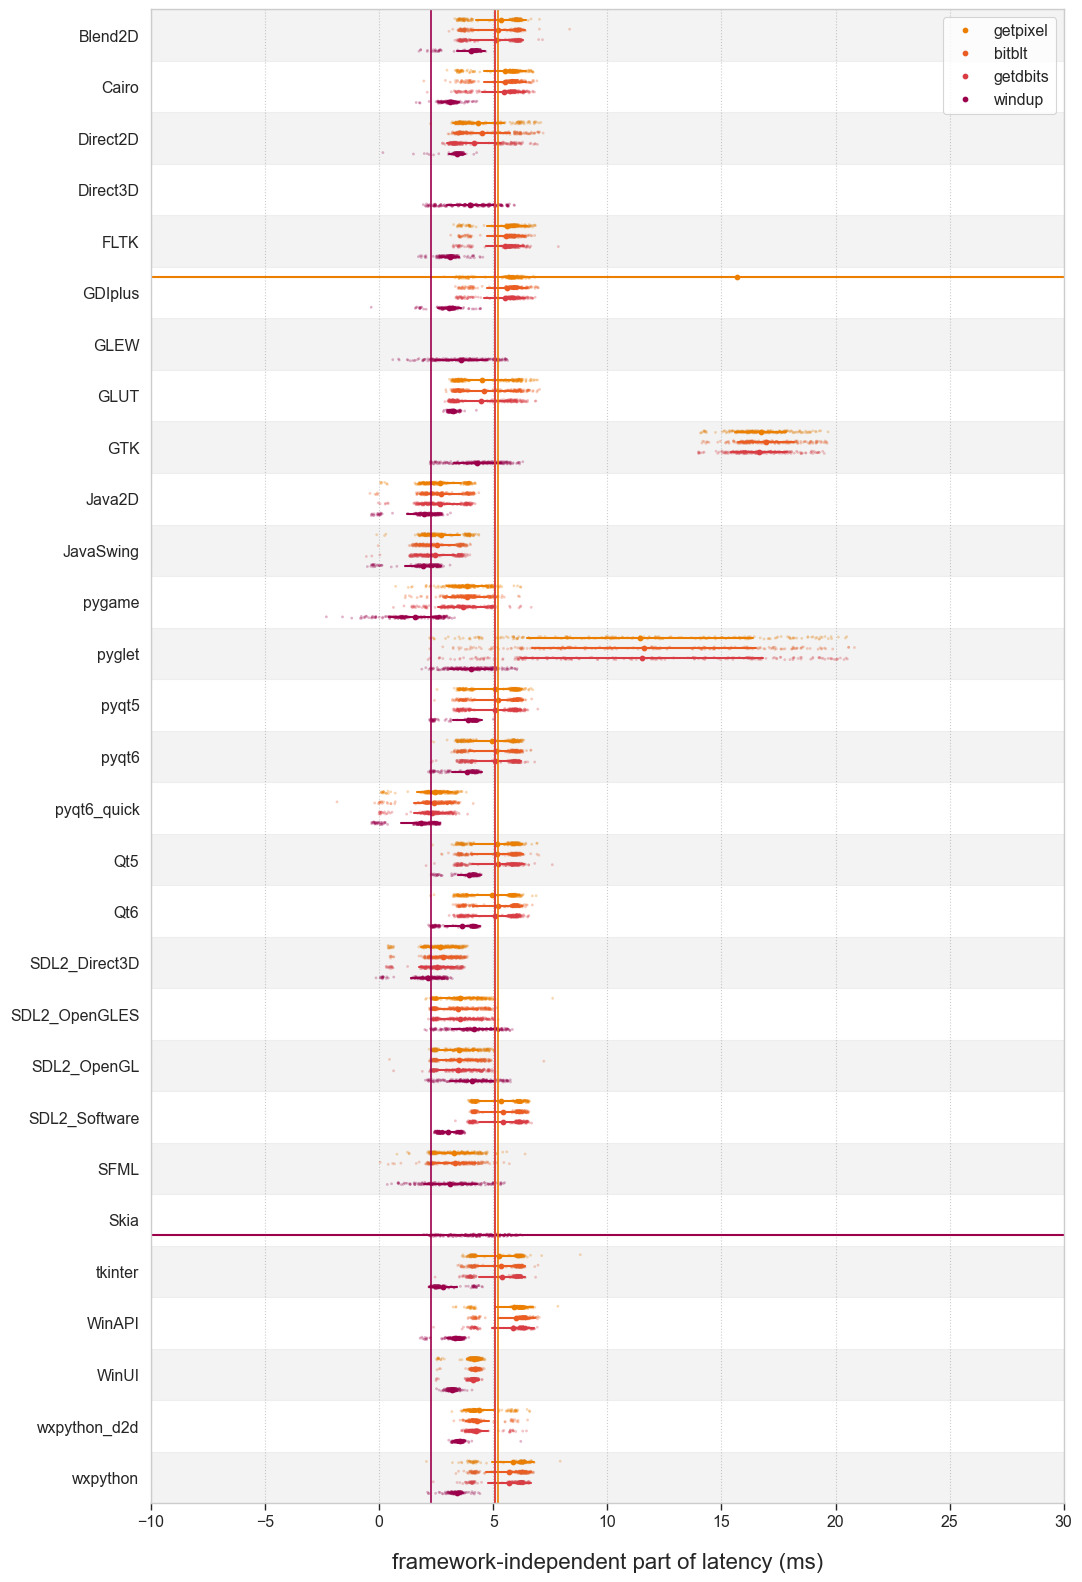

In [345]:
data_temp = data[data['fw'] != -0.001]  # exclude wherever fw measurement was not possible + no measurement program running

sns.set_theme(style="whitegrid", context="paper", font_scale=1.3, rc={'figure.figsize':(11, 16), "xtick.bottom": True, "grid.linestyle": ":"})

plot = sns.stripplot(data=data_temp, y='framework', x='diff', hue='program', hue_order=['getpixel', 'bitblt', 'getdbits', 'windup'], size=2, dodge=0.6, palette=[COLOR_OCKER_ANDI, COLOR_OCKER, COLOR_GLUTROT, COLOR_HEIDENELKE], alpha=0.3, zorder=1, legend=False)
plot = sns.pointplot(data=data_temp, y='framework', x='diff', hue='program', hue_order=['getpixel', 'bitblt', 'getdbits', 'windup'], palette=[COLOR_OCKER_ANDI, COLOR_OCKER, COLOR_GLUTROT, COLOR_HEIDENELKE], dodge=0.6, join=False, errorbar='sd', markersize=3, linewidth=1.5, zorder=2)
plot.axes.set_xlim(-10, 30)
plot.legend(title='', loc='upper right')
plot.set_xlabel('framework-independent part of latency (ms)', fontsize=16)
plot.xaxis.labelpad = 16
plot.set_ylabel('')


# stripped background
for i in range(len(data['framework'].unique())):
    if i % 2 == 0:
        plot.axhspan(i - 0.5, i + 0.5, color=COLOR_NONE, alpha=0.1)
plot.set_ylim(-0.5, len(data['framework'].unique()) - 0.5)


plt.axvline(diff_mean_getpixel, color=COLOR_OCKER_ANDI)
plt.axvline(diff_mean_bitblt, color=COLOR_OCKER)
plt.axvline(diff_mean_getdbits, color=COLOR_GLUTROT)
plt.axvline(diff_mean_windup, color=COLOR_HEIDENELKE)


plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("validation_diffs.pdf", format='pdf')



In [318]:
data_temp[data_temp['framework'] == 'GLEW']

,Unnamed: 0,id,threshold,framework,complexity,framework_complexity,fullscreen,fullscreen_mode,program,ete_upper,ete_lower,fw,diff
0,0,0,2306,GLEW,default,GLEW_default,fullscreen,3.0,windup,6.985,7.243,2.961,4.024
1,1,1,2306,GLEW,default,GLEW_default,fullscreen,3.0,windup,5.767,6.025,1.874,3.893
2,2,2,2306,GLEW,default,GLEW_default,fullscreen,3.0,windup,6.124,6.552,3.174,2.950
3,3,3,2306,GLEW,default,GLEW_default,fullscreen,3.0,windup,5.252,5.509,2.999,2.253
4,4,4,2306,GLEW,default,GLEW_default,fullscreen,3.0,windup,4.398,4.825,1.286,3.112
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,195,2306,GLEW,default,GLEW_default,fullscreen,3.0,windup,5.610,6.030,2.841,2.769
196,196,196,2306,GLEW,default,GLEW_default,fullscreen,3.0,windup,5.783,6.032,1.363,4.420
197,197,197,2306,GLEW,default,GLEW_default,fullscreen,3.0,windup,5.436,5.857,2.724,2.712
198,198,198,2306,GLEW,default,GLEW_default,fullscreen,3.0,windup,5.770,6.019,2.768,3.002


# For appraoch description (validation, best case)

In [319]:
data_temp = data[data['framework'].isin(['tkinter', 'SDL2_Direct3D'])]
data_temp = data_temp[data_temp['program'] != 'getpixel']
data_temp = data_temp[data_temp['program'] != 'bitblt']
data_temp = data_temp[data_temp['program'] != 'getdbits']
data_temp

,Unnamed: 0,id,threshold,framework,complexity,framework_complexity,fullscreen,fullscreen_mode,program,ete_upper,ete_lower,fw,diff
0,0,0,2300,SDL2_Direct3D,default,SDL2_Direct3D_default,fullscreen,NaN,none,5.095,5.522,-0.001,5.096
1,1,1,2300,SDL2_Direct3D,default,SDL2_Direct3D_default,fullscreen,NaN,none,5.259,5.346,-0.001,5.260
2,2,2,2300,SDL2_Direct3D,default,SDL2_Direct3D_default,fullscreen,NaN,none,4.573,4.822,-0.001,4.574
3,3,3,2300,SDL2_Direct3D,default,SDL2_Direct3D_default,fullscreen,NaN,none,5.085,5.334,-0.001,5.086
4,4,4,2300,SDL2_Direct3D,default,SDL2_Direct3D_default,fullscreen,NaN,none,4.050,4.477,-0.001,4.051
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,195,2306,tkinter,default,tkinter_default,fullscreen,2.0,windup,11.474,13.791,7.339,4.135
196,196,196,2306,tkinter,default,tkinter_default,fullscreen,2.0,windup,9.557,11.881,7.094,2.463
197,197,197,2306,tkinter,default,tkinter_default,fullscreen,2.0,windup,9.217,11.700,6.776,2.441
198,198,198,2306,tkinter,default,tkinter_default,fullscreen,2.0,windup,13.024,15.345,8.770,4.254


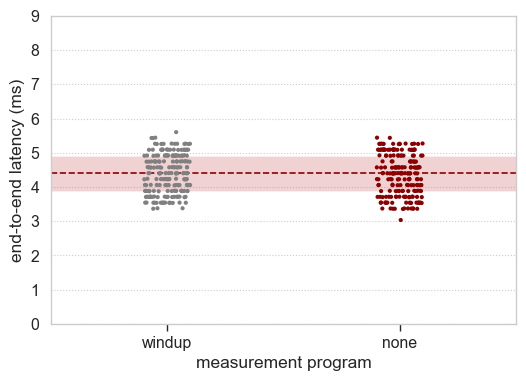

In [320]:
data_temp_2 = data_temp[data_temp['framework'] == 'SDL2_Direct3D']
sns.set_theme(style="whitegrid", context="paper", font_scale=1.3, rc={'figure.figsize':(6, 4), "xtick.bottom": True, "grid.linestyle": ":"})

plot = sns.stripplot(data=data_temp_2, x='program', y='ete_upper', order=['windup', 'none'], palette=['grey', 'darkred'], size=3)
# plot = sns.boxplot(data=data_temp, x='program', y='ete_upper', order=['windup', 'none'], palette=['grey', 'darkred'], fill=False)
plot.axhline(data_temp_2[data_temp_2['program'] == 'none']['ete_upper'].median(), color='darkred', alpha=1, linestyle='--')
plot.set_ylim(bottom=0, top=9)
plot.set_ylabel('end-to-end latency (ms)')
plot.set_xlabel('measurement program')

quant_25 = np.percentile(data_temp_2[data_temp_2['program'] == 'none']['ete_upper'], 25)
quant_75 = np.percentile(data_temp_2[data_temp_2['program'] == 'none']['ete_upper'], 75)
plot.axhspan(quant_25, quant_75, facecolor='r', alpha=0.25)